In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

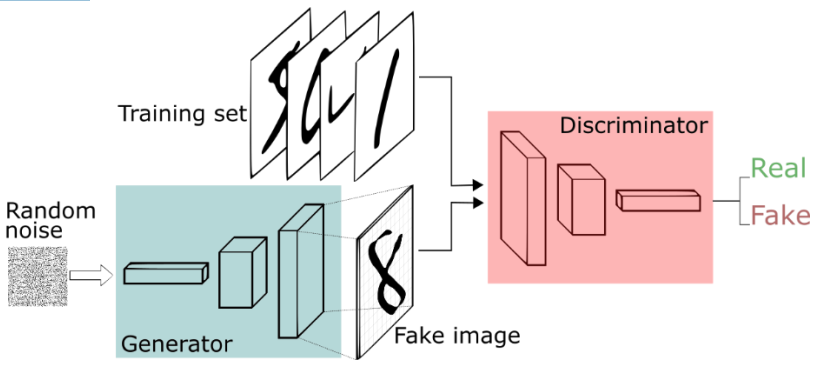

Generative Adversarial Networks (GANs) adalah  arsitektur pembelajaran mendalam yang dirancang untuk membuat data baru yang mirip dengan data pelatihan. GAN terdiri dari dua jaringan saraf yang bersaing: generator  dan diskriminator Berikut  penjelasan  cara kerja GAN seperti terlihat pada gambar yang tersedia.

**Generator**:
1. Generator adalah jaringan saraf yang tugasnya menghasilkan gambar palsu yang menyerupai gambar nyata dari set pelatihan.
2. Generator mulai dengan input berupa noise acak (random noise) yang biasanya diambil dari distribusi normal atau uniform.
3. Generator kemudian mengubah noise ini menjadi gambar melalui beberapa lapisan jaringan saraf (biasanya termasuk lapisan konvolusi transpos atau dekonvolusi).

**Training Set**:
Gambar asli yang digunakan untuk melatih GAN. Dalam contoh ini, gambar-gambar tersebut adalah digit-digit tangan dari dataset seperti MNIST.

**Discriminator**:
1. Discriminator adalah jaringan saraf yang tugasnya membedakan antara gambar nyata (dari set pelatihan) dan gambar palsu (yang dihasilkan oleh Generator).
2. Discriminator menerima gambar sebagai input dan memberikan output berupa probabilitas yang menunjukkan seberapa besar kemungkinan gambar tersebut adalah gambar nyata.

**Proses Pelatihan**:
1. GAN dilatih dalam proses yang bersifat adversarial, di mana Generator dan Discriminator berkompetisi satu sama lain.
2. Generator mencoba menghasilkan gambar yang semakin nyata untuk menipu Discriminator, sementara Discriminator belajar untuk semakin baik dalam membedakan gambar nyata dari gambar palsu.

**Loss Function**:
1. Discriminator dilatih untuk memaksimalkan probabilitas mengklasifikasikan gambar nyata dengan benar sebagai nyata dan gambar palsu sebagai palsu.
2. Generator dilatih untuk memaksimalkan probabilitas bahwa Discriminator akan salah mengklasifikasikan gambar palsu sebagai nyata.

Secara keseluruhan, tujuan dari GAN adalah untuk membuat Generator dan Discriminator belajar bersama-sama sehingga Generator akhirnya dapat menghasilkan gambar yang sangat realistis yang tidak dapat dibedakan dari gambar nyata oleh Discriminator.

Shape of test images: (10000, 28, 28)
Shape of test labels: (10000,)


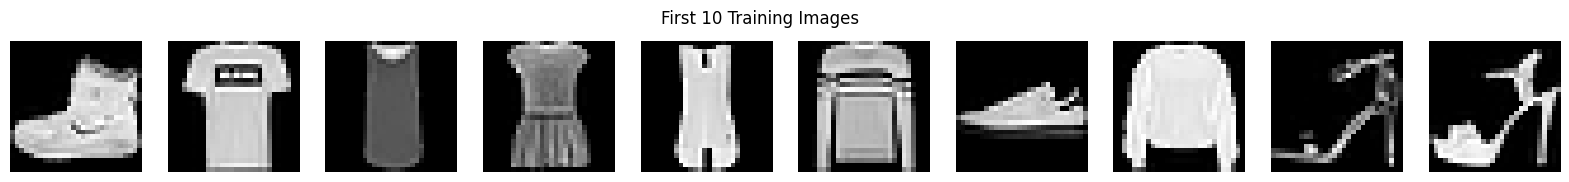

In [20]:
print(f"Shape of test images: {test_images.shape}")
print(f"Shape of test labels: {test_labels.shape}")

num_images = 10
fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
for i in range(num_images):
    axes[i].imshow(train_images[i], cmap='gray')
    axes[i].axis('off')
plt.suptitle('First 10 Training Images')
plt.show()

In [21]:
test_images = (test_images - 255) / 255

In [22]:
# Filter only the classes 4 (Coat) and 5 (Sandal)
coat_train = np.where(test_labels == 4)[0]
sandal_train = np.where(test_labels == 5)[0]

coat_train_images = test_images[coat_train]
sandal_train_images = test_images[sandal_train]

coat_train_labels = test_labels[coat_train]
sandal_train_labels = test_labels[sandal_train]

# Combine the filtered images
filtered_train_images = np.concatenate((coat_train_images, sandal_train_images), axis=0)
filtered_test_images = np.concatenate((coat_train_labels, sandal_train_labels), axis=0)

# Print the shapes of the filtered datasets
print(f"Shape of filtered train images: {filtered_train_images.shape}")
print(f"Shape of filtered test images: {filtered_test_images.shape}")

Shape of filtered train images: (2000, 28, 28)
Shape of filtered test images: (2000,)


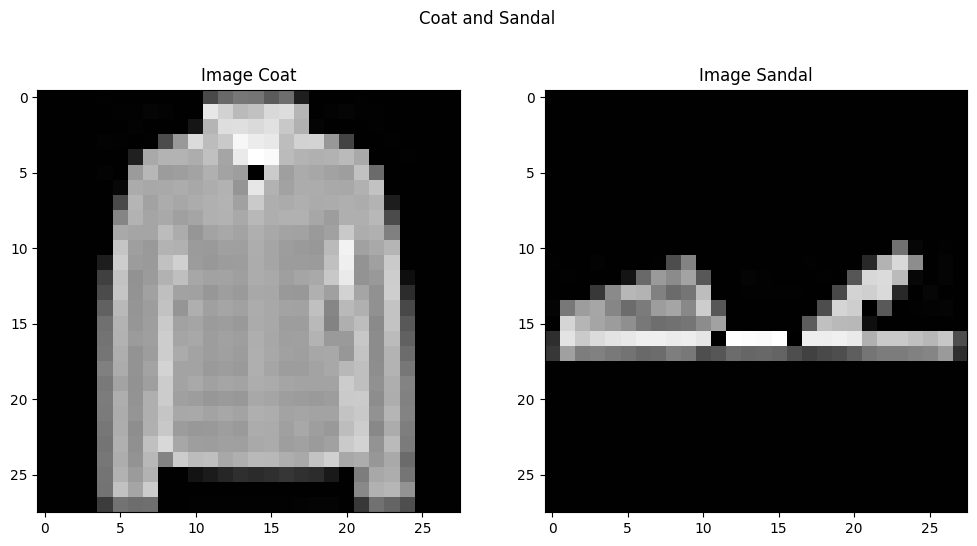

In [23]:
fig,axes = plt.subplots(1,2, figsize = (12,6))
axes[0].imshow(filtered_train_images[10], cmap='gray')
axes[0].set_title('Image Coat')

axes[1].imshow(filtered_train_images[1010], cmap='gray')
axes[1].set_title('Image Sandal')
plt.suptitle('Coat and Sandal')
plt.show()

In [24]:
filtered_train_images = filtered_train_images.reshape((-1, 28, 28, 1))

print (filtered_train_images.shape, filtered_test_images.shape)

(2000, 28, 28, 1) (2000,)


In [25]:
x_train, x_temp, y_train, y_temp = train_test_split(filtered_train_images, filtered_test_images, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
# Print the shapes of the datasets
print(f"Shape of train images: {x_train.shape},{y_train.shape}")
print(f"Shape of validation images: {x_val.shape},{y_val.shape}")
print(f"Shape of test images: {x_test.shape},{y_test.shape}")

Shape of train images: (1600, 28, 28, 1),(1600,)
Shape of validation images: (200, 28, 28, 1),(200,)
Shape of test images: (200, 28, 28, 1),(200,)


In [26]:
x_train,x_val,x_test = x_train.reshape((-1,28,28,1)),x_val.reshape((-1,28,28,1)),x_test.reshape((-1,28,28,1 ))

In [27]:
#Hyperparameters
img_shape = (28, 28, 1)
img_size = img_shape[0]
num_classes = 2
latent_dim = 120
batch_size = 128
label_dim = 2
epochs = 168
sample_interval = 60

# Generator Model
def build_generator():
    input_noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(1,),dtype='int32')
    label_embedding = layers.Embedding(num_classes, latent_dim)(label)
    label_embedding = layers.Flatten()(label_embedding)
    input_model = layers.Concatenate()([input_noise, label_embedding])
    x = layers.Dense(128, activation='relu')(input_model)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(img_size * img_size, activation='tanh')(x)
    x = layers.Reshape(img_shape)(x)
    model = models.Model([input_noise, label], x)
    return model

# Discriminator Model
def build_discriminator():
    input_img = layers.Input(shape=img_shape)
    label = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, img_size * img_size)(label)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((img_size, img_size, 1))(label_embedding)
    model_input = layers.Concatenate(axis=-1)([input_img, label_embedding])
    x = layers.Flatten()(model_input)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model([input_img, label], x)
    return model

In [28]:
Dis = build_discriminator()
Dis.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
Gen = build_generator()

In [29]:
noise = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(1,), dtype='int32')
generated_img = Gen([noise, label])
Dis.trainable = False
validity = Dis([generated_img, label])
GAN = models.Model([noise, label], validity)
GAN.compile(loss='binary_crossentropy', optimizer= Adam())
print("Generator Summary:")
Gen.summary()
print("Discriminator Summary:")
Dis.summary()
print("GAN Summary:")
GAN.summary()

Generator Summary:
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 120)               240       ['input_11[0][0]']            
                                                                                                  
 input_10 (InputLayer)       [(None, 120)]                0         []                            
                                                                                                  
 flatten_5 (Flatten)         (None, 120)                  0         ['embedding_3[0][0]']         
                                                                         

In [30]:
def train(x_train,y_train,epochs,batch_size,sample_interval):
  y_train = y_train.values if isinstance(y_train, pd.DataFrame) else y_train

  img_real = np.ones((batch_size,1))
  img_fake = np.zeros((batch_size,1))

  d_loss = []
  g_loss = []
  for epoch in range(epochs):
    index = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[index]
    labels = y_train[index] % num_classes

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = Gen.predict([noise, labels])

    d_loss_real = Dis.train_on_batch([imgs, labels], img_real)
    d_loss_fake = Dis.train_on_batch([gen_imgs, labels], img_fake)
    d_losses = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sample_labels = np.random.randint(0, label_dim, batch_size).reshape(-1, 1)
    g_losses = GAN.train_on_batch([noise, sample_labels], img_real)

    g_loss.append(d_loss)
    d_loss.append(d_loss)

    if isinstance(d_losses, list):
      print(f"{epoch} [D loss: {d_losses[0]} | D accuracy: {100*d_losses[1]}] [G loss: {g_losses}]")

    else:
      print(f"{epoch} [D loss: {d_losses}] [G loss: {g_losses}]")

    if epoch % sample_interval == 0:
      sample_img(epoch)


In [31]:
def sample_img(epoch):
  noise = np.random.normal(0, 1, (16, latent_dim))
  labels = np.random.randint(0, label_dim, 16).reshape(-1, 1)
  generated_images = Gen.predict([noise, labels])
  generated_images = 0.5 * generated_images + 0.5
  fig, axes = plt.subplots(4, 4, figsize=(10, 10))
  count = 0
  for i in range(4):
    for j in range(4):
      axes[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')
      axes[i, j].axis('off')
      count += 1
      plt.suptitle(f"Epoch {epoch}")
  plt.show()

4/4 [==============================] - 0s 3ms/step
0 [D loss: [0.88489115 0.5       ]] [G loss: 0.5609102249145508]
1/1 [==============================] - 0s 78ms/step


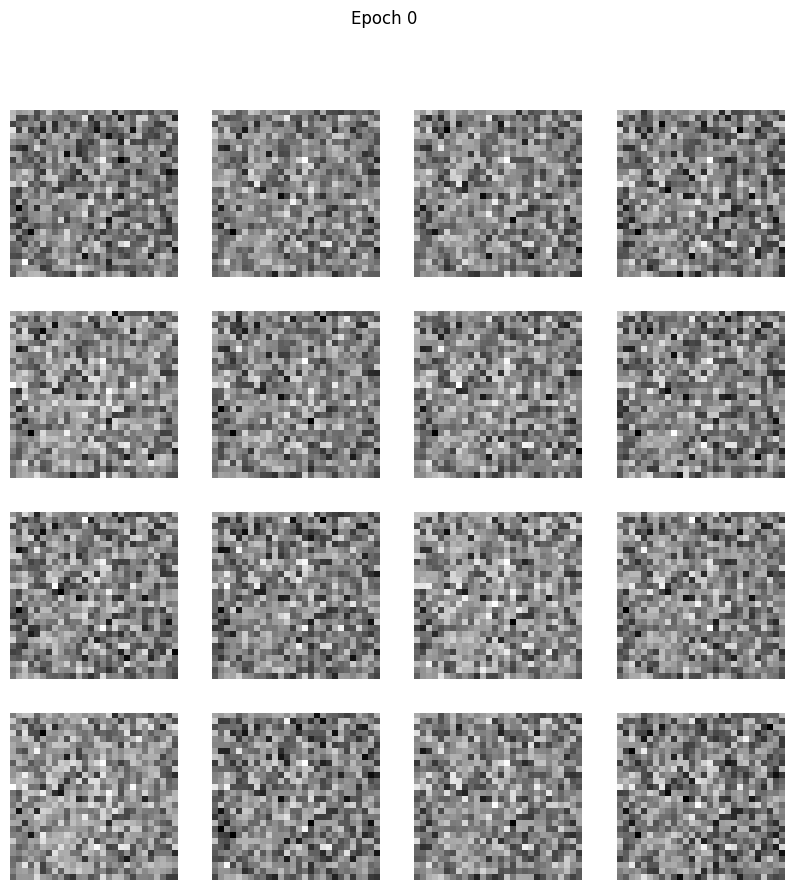

4/4 [==============================] - 0s 3ms/step
1 [D loss: [0.84735367 0.5       ]] [G loss: 0.4984697699546814]
4/4 [==============================] - 0s 4ms/step
2 [D loss: [0.59402722 0.5       ]] [G loss: 0.7346850633621216]
4/4 [==============================] - 0s 4ms/step
3 [D loss: [0.30882857 1.        ]] [G loss: 1.2149240970611572]
4/4 [==============================] - 0s 3ms/step
4 [D loss: [0.20147436 1.        ]] [G loss: 1.6255285739898682]
4/4 [==============================] - 0s 4ms/step
5 [D loss: [0.13310252 1.        ]] [G loss: 2.0601344108581543]
4/4 [==============================] - 0s 4ms/step
6 [D loss: [0.0995159 1.       ]] [G loss: 2.393123149871826]
4/4 [==============================] - 0s 3ms/step
7 [D loss: [0.08868246 1.        ]] [G loss: 2.5574660301208496]
4/4 [==============================] - 0s 4ms/step
8 [D loss: [0.08442806 1.        ]] [G loss: 2.5901999473571777]
4/4 [==============================] - 0s 3ms/step
9 [D loss: [0.08831988 1

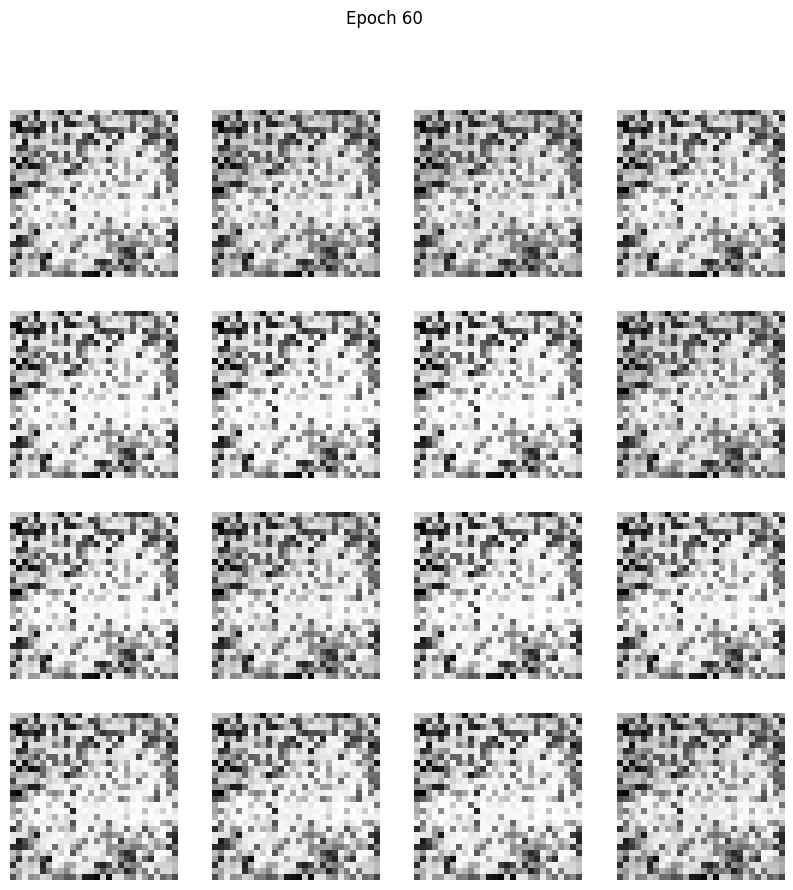

4/4 [==============================] - 0s 3ms/step
61 [D loss: [0.16554471 0.8828125 ]] [G loss: 3.664536476135254]
4/4 [==============================] - 0s 3ms/step
62 [D loss: [0.08197414 0.94921875]] [G loss: 3.697997570037842]
4/4 [==============================] - 0s 2ms/step
63 [D loss: [0.078322   0.97265625]] [G loss: 3.6376688480377197]
4/4 [==============================] - 0s 2ms/step
64 [D loss: [0.03892618 0.99609375]] [G loss: 4.016104221343994]
4/4 [==============================] - 0s 3ms/step
65 [D loss: [0.02306528 1.        ]] [G loss: 5.3170881271362305]
4/4 [==============================] - 0s 2ms/step
66 [D loss: [0.01243384 1.        ]] [G loss: 6.40285062789917]
4/4 [==============================] - 0s 2ms/step
67 [D loss: [0.00970434 1.        ]] [G loss: 7.008213520050049]
4/4 [==============================] - 0s 2ms/step
68 [D loss: [0.020067   0.98828125]] [G loss: 7.7277374267578125]
4/4 [==============================] - 0s 2ms/step
69 [D loss: [0.0079

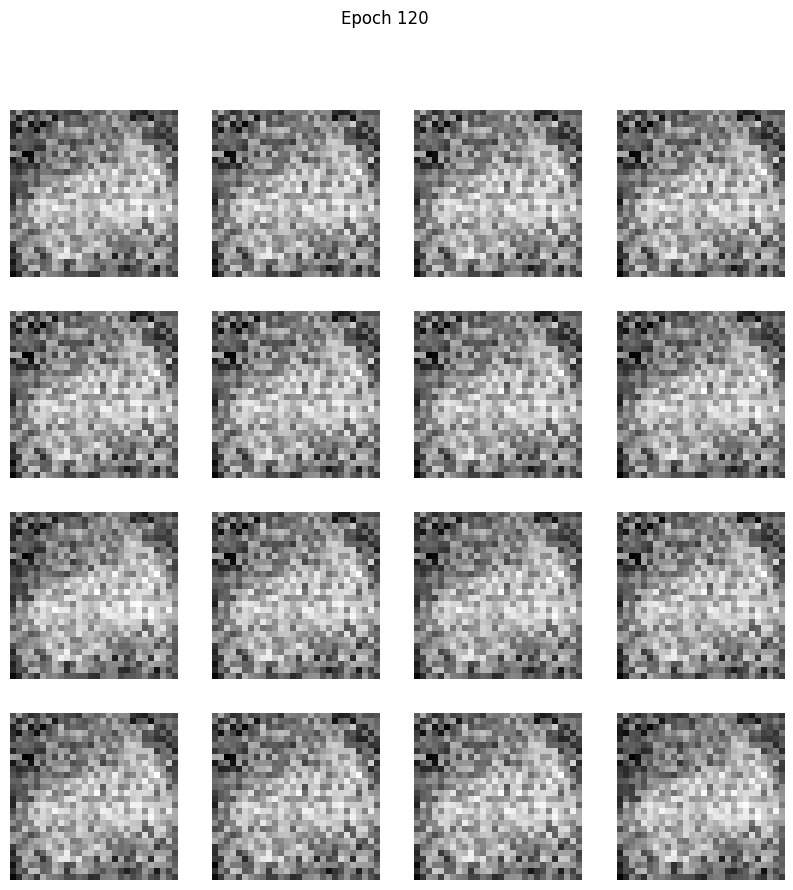

4/4 [==============================] - 0s 3ms/step
121 [D loss: [0.34610464 0.83203125]] [G loss: 2.1635727882385254]
4/4 [==============================] - 0s 3ms/step
122 [D loss: [0.25882205 0.9140625 ]] [G loss: 2.358083963394165]
4/4 [==============================] - 0s 3ms/step
123 [D loss: [0.10158136 0.97265625]] [G loss: 3.019714593887329]
4/4 [==============================] - 0s 3ms/step
124 [D loss: [0.07360042 0.98046875]] [G loss: 3.7667908668518066]
4/4 [==============================] - 0s 3ms/step
125 [D loss: [0.05344891 0.984375  ]] [G loss: 4.303286075592041]
4/4 [==============================] - 0s 3ms/step
126 [D loss: [0.0308069 1.       ]] [G loss: 4.698469161987305]
4/4 [==============================] - 0s 3ms/step
127 [D loss: [0.0212168 1.       ]] [G loss: 5.152828216552734]
4/4 [==============================] - 0s 5ms/step
128 [D loss: [0.03286568 0.98828125]] [G loss: 5.2787275314331055]
4/4 [==============================] - 0s 3ms/step
129 [D loss: [

In [32]:
train(x_train,y_train,epochs,batch_size,sample_interval)

In [33]:
def generate_img(generator, latent_dim, label_dim, num_samples):
  noise = np.random.normal(0,1,(num_samples, latent_dim))
  labels = np.random.randint(0, label_dim, num_samples).reshape(-1, 1)
  generated_images = generator.predict([noise, labels])
  return generated_images

In [34]:
gen_imgs = generate_img(Gen, latent_dim, label_dim, len(x_test))

7/7 [==============================] - 0s 2ms/step


In [35]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from scipy.linalg import sqrtm

InceptionV3_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def preprocess (images):
  images = np.array(images, dtype=np.float32)
  images = np.repeat(images, 3, axis=-1)
  resize_img = np.array([resize(image, (299, 299, 3)) for image in images])
  resize_img = preprocess_input(resize)
  return resize_img

def features(images, model):
  images = preprocess(images)
  features = model.predict(images)
  return features

def FID(features1, features2):
  img_real, sig_real = features1.mean(axis=0), np.cov(features1, rowvar=False)
  img_gen, sig_gen = features2.mean(axis=0), np.cov(features2, rowvar=False)
  diff = np.sum((img_real-img_gen)**2.0)
  cov = sqrtm(sig_gen.dot(sig_gen))
  if np.iscomplexobj(cov):
    cov = cov.real
  fid = diff + np.trace(sig_real + sig_gen - 2.0 * cov)
  return fid


In [ ]:
if isinstance(x_test, pd.DataFrame):
  x_test = x_test.values

x_test = x_test.reshape(-1, 1)

gen_imgs = generate_img(Gen, latent_dim, label_dim, len(y_test))

features1 = features(x_test, InceptionV3_model)
features2 = features(gen_imgs, InceptionV3_model)
fid = FID(features1, features2)
print(f"FID: {fid}")

7/7 [==============================] - 0s 3ms/step
